In [100]:
directory = 'ML_Algorithms_FA_23/Federated_Learning_Project' ## This is the path to my directory, obvious apart from the drive/MyDrive

from google.colab import drive ## We need to mount Google Drive to Colab's Virtual Machine
drive.mount('/content/drive', force_remount=True) ## Once you try to mount the drive, you need to authorize it with your google account
import os
os.chdir('/content/drive/My Drive/' + directory) ## Now we just concatenate the drive to be in this specificed path

Mounted at /content/drive


In [101]:
# !pip install --quiet --upgrade tensorflow-federated

In [102]:
import yfinance as yf
import plotly.graph_objects as go
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Constants
SEQ_LEN = 90
EPOCHS = 60
BATCH_SIZE = 256
D_MODEL = 300
FUTURE_PERIOD = 10;

# def fetch_stock_data(ticker_symbol):
#     try:
#         end_date = datetime.datetime.now()
#         start_date = end_date - datetime.timedelta(days=365)  # Fetch data for the last 365 days (1 year)

#         # Download all available stock data at 60-minute intervals within the last 365 days
#         stock_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='60m')

#         return stock_data
#     except Exception as e:
#         print(f"Error fetching data for {ticker_symbol}: {e}")
#         return None

def fetch_stock_data(ticker_symbol):
    try:
        stock_data = yf.download(ticker_symbol)

        return stock_data
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None

# def fetch_stock_data(ticker_symbol):
#     try:
#         # Define the start and end dates
#         start_date = datetime.datetime(2010, 1, 1)
#         end_date = datetime.datetime.now()

#         # Download stock data from start_date to end_date
#         stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

#         return stock_data
#     except Exception as e:
#         print(f"Error fetching data for {ticker_symbol}: {e}")
#         return None

def process_data(df, SEQ_LEN, FUTURE_PERIOD):
    # Reverse the DataFrame if the dates are in descending order
    ## df = df.iloc[::-1]

    # Calculate the sizes for each dataset based on percentages
    test_size = int(0.1 * len(df))
    validation_size = int(0.2 * len(df))
    train_size = len(df) - test_size - validation_size

    # Adjust the sizes to account for SEQ_LEN and FUTURE_PERIOD
    train_size -= (SEQ_LEN + FUTURE_PERIOD - 1)
    validation_size -= (FUTURE_PERIOD - 1)

    # Split the dataframes based on the adjusted sizes
    train_df = df.iloc[:train_size]
    validation_df = df.iloc[train_size:train_size + validation_size]
    test_df = df.iloc[-test_size:]

    return train_df, validation_df, test_df

# Utility function to apply exponential moving average (EMA) to smooth out the data
def apply_ema(data, gamma=0.1):
    EMA = 0.0
    for ti in range(data.shape[0]):
        EMA = gamma * data[ti] + (1 - gamma) * EMA
        data[ti] = EMA
    return data

# Utility function to create the sequence data
def split_data(data, SEQ_LEN, FUTURE_PERIOD):
    X, Y = [], []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])  # Assuming column 3 is the 'Close' column
    return np.array(X), np.array(Y)

def preprocess_data(train_df, validation_df, test_df, SEQ_LEN, FUTURE_PERIOD=10):
    # Converting DataFrames to numpy arrays for the MinMaxScaler
    train_ = train_df.values
    valid_ = validation_df.values
    test_ = test_df.values

    # Extract date indices for each dataset
    train_dates = train_df.index
    valid_dates = validation_df.index
    test_dates = test_df.index

    # Setting up the MinMaxScaler and scaling the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_)
    valid_scaled = scaler.transform(valid_)
    test_scaled = scaler.transform(test_)

    # Apply EMA to smooth out the data
    train_scaled = apply_ema(train_scaled)

    # Splitting the data into features and target sets
    X_train, y_train = split_data(train_scaled, SEQ_LEN, FUTURE_PERIOD)
    X_valid, y_valid = split_data(valid_scaled, SEQ_LEN, FUTURE_PERIOD)
    X_test, y_test = split_data(test_scaled, SEQ_LEN, FUTURE_PERIOD)

    # Reshaping the input to be compatible with LSTM (if needed)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    return (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), scaler

def plot_stock_data(company, df, X_train, y_train, X_valid, y_valid, X_test, y_test, SEQ_LEN):
    # Calculate the start index for each set
    train_start_idx = SEQ_LEN
    valid_start_idx = len(X_train) + SEQ_LEN
    test_start_idx = len(X_train) + len(X_valid) + SEQ_LEN

    # Select the corresponding dates for each dataset
    train_dates = df.index[train_start_idx:train_start_idx + len(X_train)]
    valid_dates = df.index[valid_start_idx:valid_start_idx + len(X_valid)]
    test_dates = df.index[test_start_idx:test_start_idx + len(X_test)]

    # Create plot traces
    trace_train = go.Scatter(x=train_dates, y=y_train.flatten(), mode='lines', name='Train Target', line=dict(color='blue'))
    trace_valid = go.Scatter(x=valid_dates, y=y_valid.flatten(), mode='lines', name='Validation Target', line=dict(color='gray'))
    trace_test = go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Test Target', line=dict(color='black'))

    # Define the layout
    layout = go.Layout(
        title=f'Train, Validation, and Test Targets for {company}',
        xaxis=dict(title='Date'),
        yaxis=dict(title='Normalized Price'),
        hovermode='closest'
    )

    # Construct and show the figure
    fig = go.Figure(data=[trace_train, trace_valid, trace_test], layout=layout)
    fig.show()

def main():
    companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
                 "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "LUV",
                 "UA", "WBA", "XRX", "YUM", "GRPN"]

    all_processed_data = {}

    for company in companies:
        stock_data = fetch_stock_data(company)
        if stock_data is not None:
            train_df, validation_df, test_df = process_data(stock_data, SEQ_LEN, FUTURE_PERIOD)
            processed_data = preprocess_data(train_df, validation_df, test_df, SEQ_LEN)
            all_processed_data[company] = (processed_data, stock_data)  # Include stock_data in all_processed_data

    # Now iterate over each company and plot its data
    for company, (data, stock_data) in all_processed_data.items():
        (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), company_scaler = data
        plot_stock_data(company, stock_data, X_train, y_train, X_valid, y_valid, X_test, y_test, SEQ_LEN)

    return None

main()

Output hidden; open in https://colab.research.google.com to view.

In [103]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D,
    concatenate, Dense, Layer, Dropout, Lambda, Activation, TimeDistributed, Add, Conv1D
)
from tensorflow.keras.initializers import Ones, Zeros
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [104]:
# Custom Learning Rate Scheduler
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is float
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)
            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)

            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]])
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)
                ks = self.ks_layers[i](k)
                vs = self.vs_layers[i](v)
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x)
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    def GetPosEncodingMatrix(max_len, d_emb):
        pos_enc = np.array([
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0 else np.zeros(d_emb)
            for pos in range(max_len)
            ])
        pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
        pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
        return pos_enc

    def GetPadMask(q, k):
        ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
        mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
        mask = K.batch_dot(ones, mask, axes=[2,1])
        return mask

    def GetSubMask(s):
        len_s = tf.shape(s)[1]
        bs = tf.shape(s)[:1]
        mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
        return mask

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

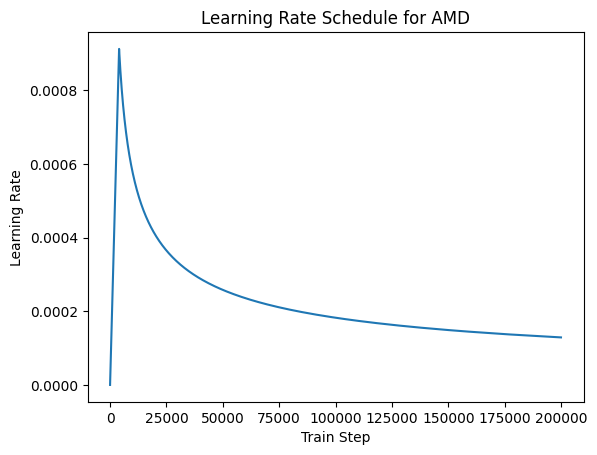

Training model for ATVI...
Epoch 1/60
20/20 [==============================] - 105s 5s/step - loss: 0.0561 - val_loss: 4.9135
Epoch 2/60
20/20 [==============================] - 87s 4s/step - loss: 0.0265 - val_loss: 4.5130
Epoch 3/60
20/20 [==============================] - 87s 4s/step - loss: 0.0080 - val_loss: 4.0564
Epoch 4/60
20/20 [==============================] - 89s 5s/step - loss: 0.0043 - val_loss: 3.6550
Epoch 5/60
20/20 [==============================] - 90s 5s/step - loss: 0.0036 - val_loss: 3.4562
Epoch 6/60
20/20 [==============================] - 87s 4s/step - loss: 0.0031 - val_loss: 3.3186
Epoch 7/60
20/20 [==============================] - 87s 4s/step - loss: 0.0029 - val_loss: 3.0793
Epoch 8/60
20/20 [==============================] - 91s 5s/step - loss: 0.0030 - val_loss: 3.1050
Epoch 9/60
20/20 [==============================] - 87s 4s/step - loss: 0.0027 - val_loss: 3.0139
Epoch 10/60
20/20 [==============================] - 86s 4s/step - loss: 0.0026 - val_loss

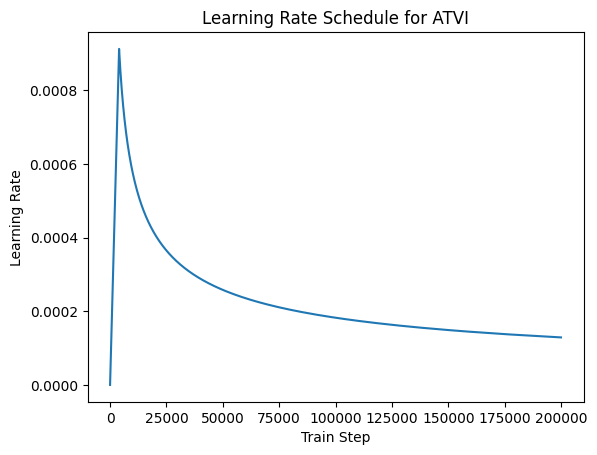

Training model for AAL...
Epoch 1/60
12/12 [==============================] - 66s 4s/step - loss: 0.2001 - val_loss: 0.0325
Epoch 2/60
12/12 [==============================] - 51s 4s/step - loss: 0.1233 - val_loss: 0.0507
Epoch 3/60
12/12 [==============================] - 57s 5s/step - loss: 0.0477 - val_loss: 0.0753
Epoch 4/60
12/12 [==============================] - 49s 4s/step - loss: 0.0317 - val_loss: 0.0641


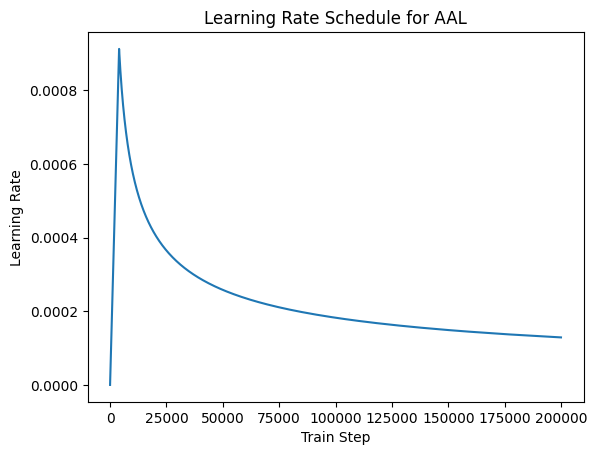

Training model for BB...
Epoch 1/60
17/17 [==============================] - 81s 4s/step - loss: 0.0916 - val_loss: 0.1422
Epoch 2/60
17/17 [==============================] - 69s 4s/step - loss: 0.0330 - val_loss: 0.0300
Epoch 3/60
17/17 [==============================] - 70s 4s/step - loss: 0.0207 - val_loss: 0.0469
Epoch 4/60
17/17 [==============================] - 69s 4s/step - loss: 0.0116 - val_loss: 0.0186
Epoch 5/60
17/17 [==============================] - 77s 5s/step - loss: 0.0073 - val_loss: 0.0109
Epoch 6/60
17/17 [==============================] - 70s 4s/step - loss: 0.0058 - val_loss: 0.0055
Epoch 7/60
17/17 [==============================] - 70s 4s/step - loss: 0.0053 - val_loss: 0.0043
Epoch 8/60
17/17 [==============================] - 73s 4s/step - loss: 0.0052 - val_loss: 0.0038
Epoch 9/60
17/17 [==============================] - 72s 4s/step - loss: 0.0048 - val_loss: 0.0030
Epoch 10/60
17/17 [==============================] - 76s 4s/step - loss: 0.0046 - val_loss: 0

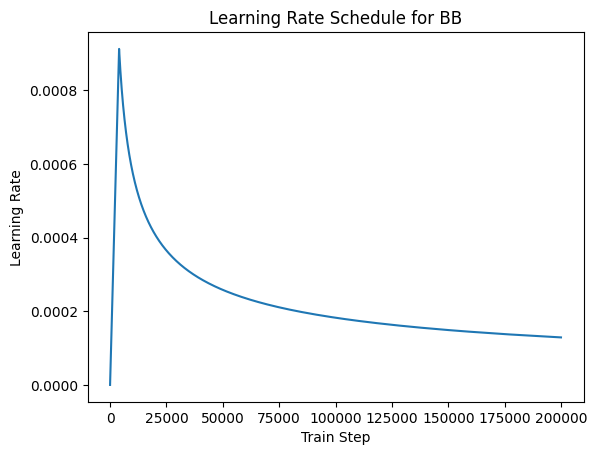

Training model for CCL...
Epoch 1/60
25/25 [==============================] - 131s 5s/step - loss: 0.1029 - val_loss: 0.3055
Epoch 2/60
25/25 [==============================] - 107s 4s/step - loss: 0.0427 - val_loss: 0.2186
Epoch 3/60
25/25 [==============================] - 103s 4s/step - loss: 0.0158 - val_loss: 0.1225
Epoch 4/60
25/25 [==============================] - 107s 4s/step - loss: 0.0069 - val_loss: 0.0601
Epoch 5/60
25/25 [==============================] - 107s 4s/step - loss: 0.0051 - val_loss: 0.0400
Epoch 6/60
25/25 [==============================] - 104s 4s/step - loss: 0.0047 - val_loss: 0.0328
Epoch 7/60
25/25 [==============================] - 104s 4s/step - loss: 0.0044 - val_loss: 0.0367
Epoch 8/60
25/25 [==============================] - 108s 4s/step - loss: 0.0041 - val_loss: 0.0258
Epoch 9/60
25/25 [==============================] - 105s 4s/step - loss: 0.0040 - val_loss: 0.0226
Epoch 10/60
25/25 [==============================] - 105s 4s/step - loss: 0.0038 - 

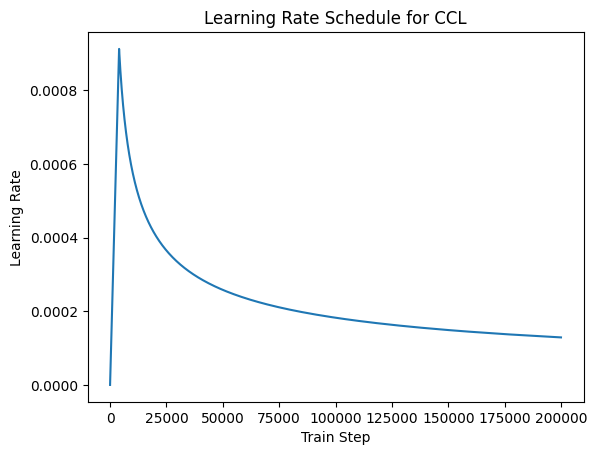

Training model for DBX...
Epoch 1/60
4/4 [==============================] - 29s 4s/step - loss: 0.0390 - val_loss: 0.0050
Epoch 2/60
4/4 [==============================] - 12s 3s/step - loss: 0.0378 - val_loss: 0.0038
Epoch 3/60
4/4 [==============================] - 14s 3s/step - loss: 0.0335 - val_loss: 0.0024
Epoch 4/60
4/4 [==============================] - 14s 4s/step - loss: 0.0272 - val_loss: 0.0023
Epoch 5/60
4/4 [==============================] - 14s 3s/step - loss: 0.0214 - val_loss: 0.0061
Epoch 6/60
4/4 [==============================] - 12s 3s/step - loss: 0.0171 - val_loss: 0.0151
Epoch 7/60
4/4 [==============================] - 14s 3s/step - loss: 0.0190 - val_loss: 0.0209


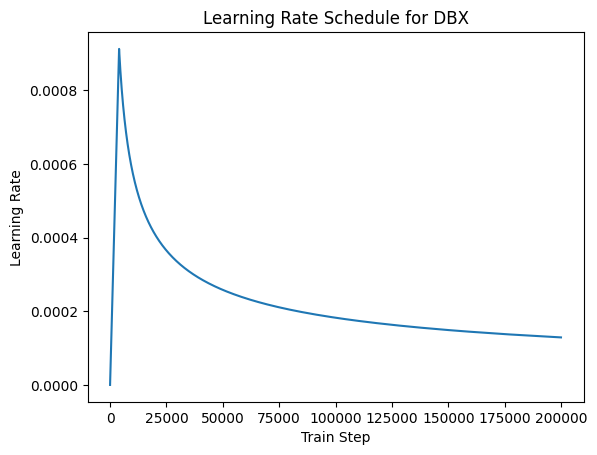

Training model for F...
Epoch 1/60
35/35 [==============================] - 178s 5s/step - loss: 0.4564 - val_loss: 0.0664
Epoch 2/60
35/35 [==============================] - 161s 5s/step - loss: 0.0342 - val_loss: 0.0188
Epoch 3/60
35/35 [==============================] - 160s 5s/step - loss: 0.0106 - val_loss: 0.0105
Epoch 4/60
35/35 [==============================] - 148s 4s/step - loss: 0.0039 - val_loss: 0.0045
Epoch 5/60
35/35 [==============================] - 155s 4s/step - loss: 0.0023 - val_loss: 0.0031
Epoch 6/60
35/35 [==============================] - 153s 4s/step - loss: 0.0019 - val_loss: 0.0034
Epoch 7/60
35/35 [==============================] - 156s 4s/step - loss: 0.0017 - val_loss: 0.0031
Epoch 8/60
35/35 [==============================] - 154s 4s/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/60
35/35 [==============================] - 151s 4s/step - loss: 0.0015 - val_loss: 0.0023
Epoch 10/60
35/35 [==============================] - 157s 5s/step - loss: 0.0017 - va

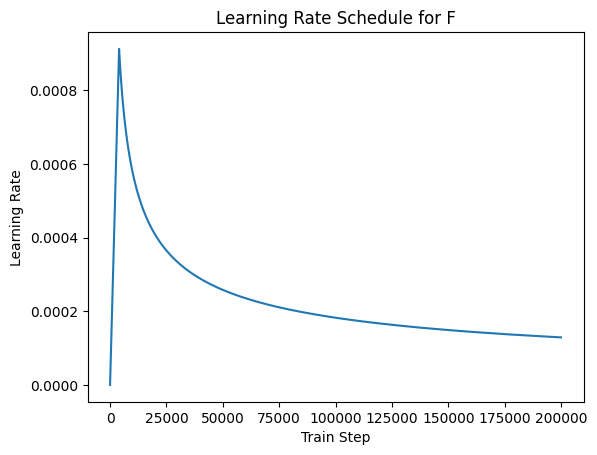

Training model for GPS...
Epoch 1/60
30/30 [==============================] - 149s 5s/step - loss: 0.1331 - val_loss: 0.1518
Epoch 2/60
30/30 [==============================] - 128s 4s/step - loss: 0.0184 - val_loss: 0.0834
Epoch 3/60
30/30 [==============================] - 130s 4s/step - loss: 0.0056 - val_loss: 0.0328
Epoch 4/60
30/30 [==============================] - 132s 4s/step - loss: 0.0031 - val_loss: 0.0154
Epoch 5/60
30/30 [==============================] - 133s 4s/step - loss: 0.0028 - val_loss: 0.0178
Epoch 6/60
30/30 [==============================] - 133s 4s/step - loss: 0.0029 - val_loss: 0.0118
Epoch 7/60
30/30 [==============================] - 127s 4s/step - loss: 0.0029 - val_loss: 0.0184
Epoch 8/60
30/30 [==============================] - 130s 4s/step - loss: 0.0027 - val_loss: 0.0149
Epoch 9/60
30/30 [==============================] - 130s 4s/step - loss: 0.0025 - val_loss: 0.0218


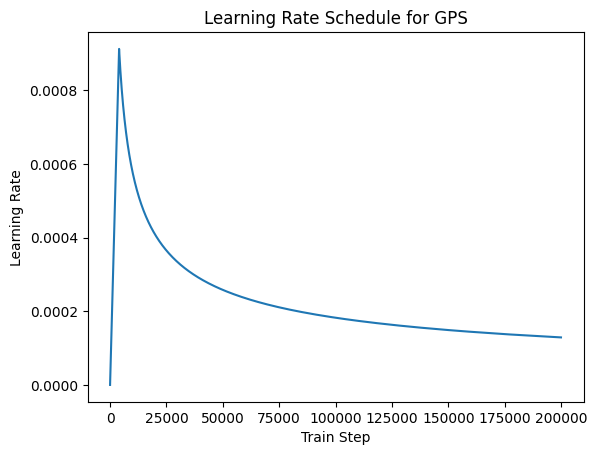

Training model for HPE...
Epoch 1/60
5/5 [==============================] - 35s 5s/step - loss: 0.1236 - val_loss: 0.1957
Epoch 2/60
5/5 [==============================] - 23s 4s/step - loss: 0.1161 - val_loss: 0.1863
Epoch 3/60
5/5 [==============================] - 21s 4s/step - loss: 0.0987 - val_loss: 0.1702
Epoch 4/60
5/5 [==============================] - 20s 4s/step - loss: 0.0744 - val_loss: 0.1478
Epoch 5/60
5/5 [==============================] - 20s 4s/step - loss: 0.0506 - val_loss: 0.1219
Epoch 6/60
5/5 [==============================] - 20s 4s/step - loss: 0.0364 - val_loss: 0.1001
Epoch 7/60
5/5 [==============================] - 22s 4s/step - loss: 0.0370 - val_loss: 0.0890
Epoch 8/60
5/5 [==============================] - 25s 5s/step - loss: 0.0385 - val_loss: 0.0918
Epoch 9/60
5/5 [==============================] - 20s 4s/step - loss: 0.0341 - val_loss: 0.1060
Epoch 10/60
5/5 [==============================] - 21s 4s/step - loss: 0.0286 - val_loss: 0.1234


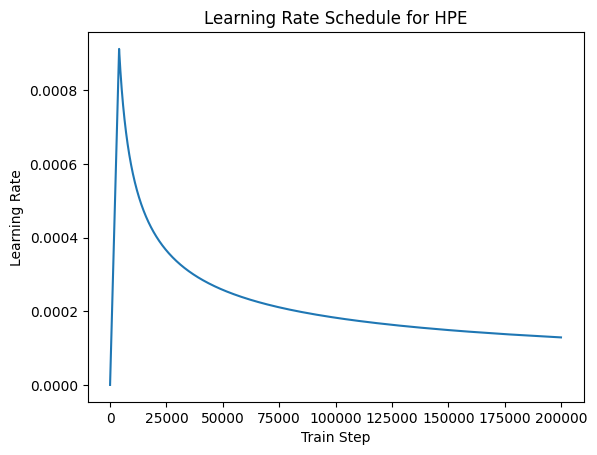

Training model for INTC...
Epoch 1/60
30/30 [==============================] - 149s 5s/step - loss: 0.3590 - val_loss: 0.0171
Epoch 2/60
30/30 [==============================] - 129s 4s/step - loss: 0.0317 - val_loss: 0.0548
Epoch 3/60
30/30 [==============================] - 132s 4s/step - loss: 0.0082 - val_loss: 0.0284
Epoch 4/60
30/30 [==============================] - 134s 5s/step - loss: 0.0048 - val_loss: 0.0276


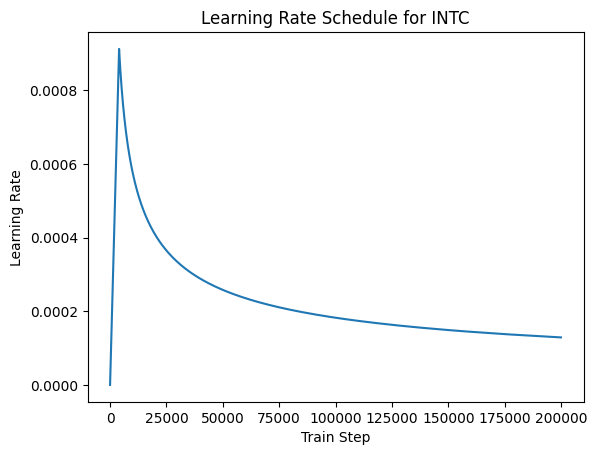

Training model for JBLU...
Epoch 1/60
15/15 [==============================] - 77s 4s/step - loss: 0.1374 - val_loss: 0.0455
Epoch 2/60
15/15 [==============================] - 64s 4s/step - loss: 0.0662 - val_loss: 0.0282
Epoch 3/60
15/15 [==============================] - 64s 4s/step - loss: 0.0358 - val_loss: 0.0174
Epoch 4/60
15/15 [==============================] - 60s 4s/step - loss: 0.0183 - val_loss: 0.0267
Epoch 5/60
15/15 [==============================] - 67s 4s/step - loss: 0.0117 - val_loss: 0.0208
Epoch 6/60
15/15 [==============================] - 62s 4s/step - loss: 0.0091 - val_loss: 0.0262


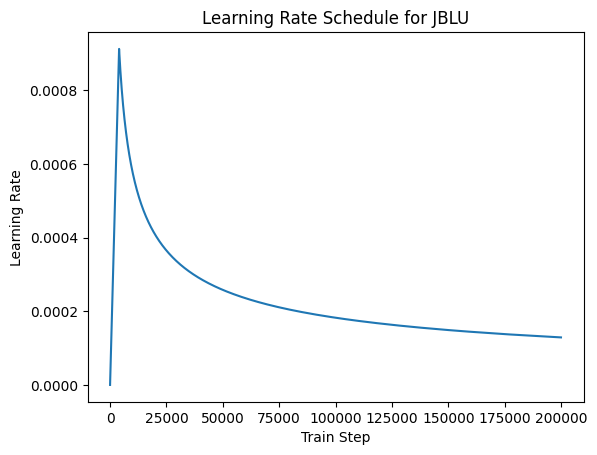

Training model for KSS...
Epoch 1/60
21/21 [==============================] - 106s 5s/step - loss: 0.1443 - val_loss: 0.0346
Epoch 2/60
21/21 [==============================] - 95s 4s/step - loss: 0.0613 - val_loss: 0.0230
Epoch 3/60
21/21 [==============================] - 94s 5s/step - loss: 0.0277 - val_loss: 0.0221
Epoch 4/60
21/21 [==============================] - 90s 4s/step - loss: 0.0125 - val_loss: 0.0232
Epoch 5/60
21/21 [==============================] - 94s 5s/step - loss: 0.0065 - val_loss: 0.0254
Epoch 6/60
21/21 [==============================] - 90s 4s/step - loss: 0.0044 - val_loss: 0.0294


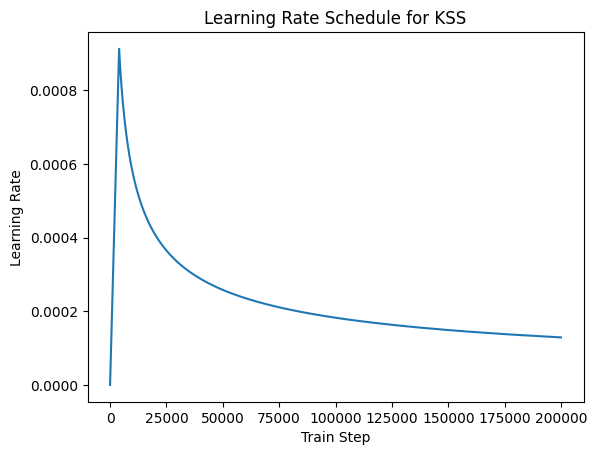

Training model for LEVI...
Epoch 1/60
3/3 [==============================] - 24s 4s/step - loss: 0.1794 - val_loss: 0.0110
Epoch 2/60
3/3 [==============================] - 11s 3s/step - loss: 0.1766 - val_loss: 0.0123
Epoch 3/60
3/3 [==============================] - 12s 4s/step - loss: 0.1723 - val_loss: 0.0147
Epoch 4/60
3/3 [==============================] - 9s 3s/step - loss: 0.1648 - val_loss: 0.0190


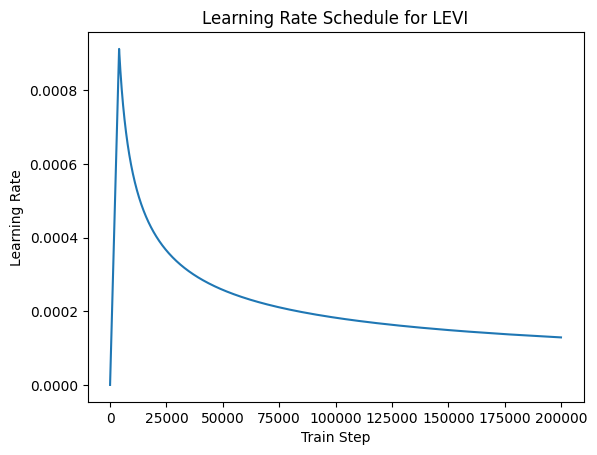

Training model for M...
Epoch 1/60
22/22 [==============================] - 111s 4s/step - loss: 0.1086 - val_loss: 0.1298
Epoch 2/60
22/22 [==============================] - 98s 4s/step - loss: 0.0471 - val_loss: 0.1172
Epoch 3/60
22/22 [==============================] - 92s 4s/step - loss: 0.0275 - val_loss: 0.0852
Epoch 4/60
22/22 [==============================] - 91s 4s/step - loss: 0.0142 - val_loss: 0.0614
Epoch 5/60
22/22 [==============================] - 95s 4s/step - loss: 0.0068 - val_loss: 0.0501
Epoch 6/60
22/22 [==============================] - 96s 4s/step - loss: 0.0048 - val_loss: 0.0583
Epoch 7/60
22/22 [==============================] - 94s 4s/step - loss: 0.0041 - val_loss: 0.0698
Epoch 8/60
22/22 [==============================] - 103s 5s/step - loss: 0.0038 - val_loss: 0.0733


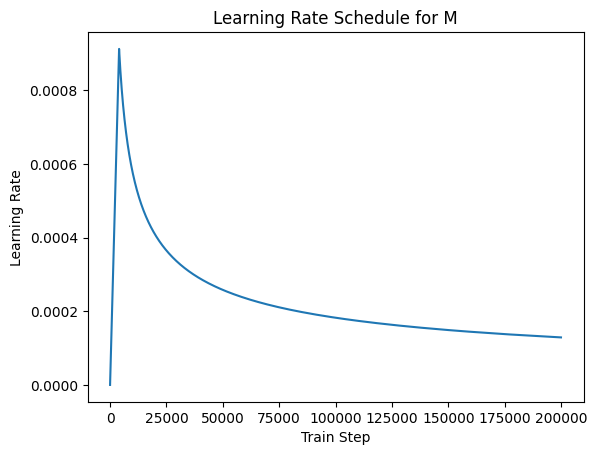

Training model for NOK...
Epoch 1/60
20/20 [==============================] - 101s 5s/step - loss: 0.0660 - val_loss: 0.1027
Epoch 2/60
20/20 [==============================] - 91s 5s/step - loss: 0.0350 - val_loss: 0.3067
Epoch 3/60
20/20 [==============================] - 87s 4s/step - loss: 0.0144 - val_loss: 0.1623
Epoch 4/60
20/20 [==============================] - 87s 4s/step - loss: 0.0078 - val_loss: 0.0546
Epoch 5/60
20/20 [==============================] - 89s 4s/step - loss: 0.0051 - val_loss: 0.0419
Epoch 6/60
19/20 [===========================>..] - ETA: 4s - loss: 0.0042

In [ ]:
%%time

def main_func2():
    companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
                 "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "LUV",
                 "UA", "WBA", "XRX", "YUM", "GRPN"]

    all_processed_data = {}

    for company in companies:
        stock_data = fetch_stock_data(company)
        if stock_data is not None:
            train_df, validation_df, test_df = process_data(stock_data, SEQ_LEN, FUTURE_PERIOD)
            processed_data = preprocess_data(train_df, validation_df, test_df, SEQ_LEN)
            all_processed_data[company] = processed_data

    return all_processed_data

# Execute the main function
all_data = main_func2()

# Build the combined LSTM and Transformer model
def build_model(seq_len, feature_dim):
    inp = Input(shape=(seq_len, feature_dim))

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    # Assuming EncoderLayer and other necessary custom classes are defined correctly
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512,
            n_head=4,
            d_k=64,
            d_v=64,
            dropout=0.2)(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=inp, outputs=x)
    return model

# Initialize the learning rate scheduler
lr_schedule = CustomeLearningSchedule(D_MODEL)

# Dictionary to store the best models for each company
best_models = {}

for company in all_data:
    print(f"Training model for {company}...")

    # Accessing and shuffling data for the current company
    (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), company_scaler = all_data[company]
    X_train, y_train = shuffle(X_train, y_train)

    # Initialize the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    # Build and compile the model for the current company
    multi_head = build_model(SEQ_LEN, X_train.shape[2])
    multi_head.compile(loss="mean_squared_error", optimizer=optimizer)

    # Training the model for the current company
    history = multi_head.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_valid, y_valid),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    # Store the model with the best weights for the current company
    best_models[company] = multi_head

    # Plotting the learning rate schedule
    steps = tf.range(200000, dtype=tf.float32)
    plt.plot(lr_schedule(steps))
    plt.ylabel("Learning Rate")
    plt.xlabel("Train Step")
    plt.title(f'Learning Rate Schedule for {company}')
    plt.show()

In [ ]:
tf.keras.utils.plot_model(multi_head, to_file="LSTM_Architecture/multi_head_net.png", show_shapes=True)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import numpy as np

# Constants
SEQ_LEN = 60
# Assuming num_features will be determined for each company dataset

for company in all_data.keys():
    print(f"Predicting and plotting for {company}...")

    # Accessing data for the current company
    (X_train, y_train, train_dates), (X_valid, y_valid, valid_dates), (X_test, y_test, test_dates), scaler = all_data[company]

    num_features = X_train.shape[2]  # Determine num_features based on current company's dataset

    # Predict with the best model for the current company
    predicted_stock_price = best_models[company].predict(X_test)

    # Rescale the predictions and actual values
    dummy_data = np.zeros((predicted_stock_price.shape[0], num_features))
    dummy_data[:, 0] = predicted_stock_price.flatten()
    predicted_stock_price_rescaled = scaler.inverse_transform(dummy_data)[:, 0]

    dummy_data_test = np.zeros((y_test.shape[0], num_features))
    dummy_data_test[:, 0] = y_test.flatten()
    y_test_rescaled = scaler.inverse_transform(dummy_data_test)[:, 0]

    # Use the test dates extracted from all_data for plotting
    # test_dates variable already holds the date information

    # Plotting the results
    trace1 = go.Scatter(x=test_dates, y=y_test_rescaled.flatten(), mode='lines', name='Actual Stock Price')
    trace2 = go.Scatter(x=test_dates, y=predicted_stock_price_rescaled.flatten(), mode='lines', name='Predicted Stock Price')

    fig = make_subplots(rows=1, cols=1)
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=1, col=1)

    fig.update_layout(title=f'{company} Stock Price Prediction', xaxis_title='Date', yaxis_title='Stock Price')
    fig.write_html(f'./Forecasts/{company}_stock_price_prediction.html')
    fig.show()

# Federated Learning Implementation